# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [1]:
model_name = None

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import re
from datetime import datetime
import collections
from readInImages import readInImages
from readInAnnotations import readInAnnotations

In [3]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [4]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [5]:
%run readInDataset.py true true 20160724_July

args: ['readInDataset.py', 'true', 'true', '20160724_July']
using_batch_generator? True
doing pre-processing? True
dataset_names: ['20160724_July']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames length: 230
done current subset
reading 

In [6]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

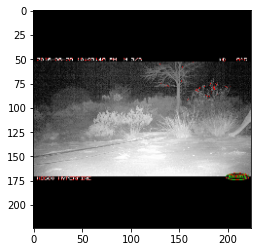

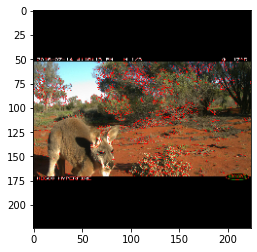

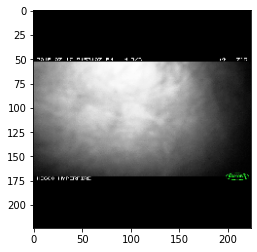

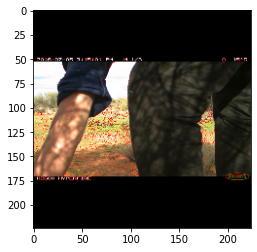

In [7]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(cv2.cvtColor(training_images[1], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[10], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[100], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[1000], cv2.COLOR_BGR2RGB))

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Train the model

In [8]:
model = tf.keras.models.Sequential([                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5),
                       tf.keras.metrics.Precision(0.5), tf.keras.metrics.Recall(0.5),
                       tf.keras.metrics.AUC(curve='PR')])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
    factor=0.1, patience=1, \
    min_lr=0.00001)

model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=15,
          callbacks=[reduce_lr])

Epoch 1/15


2022-06-08 09:26:47.645599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 09:26:47.648782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 09:26:47.648986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 09:26:47.649724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

35/35 [==============================] - 12s 230ms/step - loss: 1.6209 - accuracy: 0.5132 - top_k_categorical_accuracy: 0.9613 - precision: 0.5766 - recall: 0.3886 - auc: 0.4574 - val_loss: 1.2466 - val_accuracy: 0.5961 - val_top_k_categorical_accuracy: 0.9768 - val_precision: 0.5961 - val_recall: 0.5961 - val_auc: 0.5983 - lr: 0.0100
Epoch 2/15
35/35 [==============================] - 6s 166ms/step - loss: 1.1345 - accuracy: 0.5988 - top_k_categorical_accuracy: 0.9857 - precision: 0.6702 - recall: 0.4803 - auc: 0.6016 - val_loss: 1.1270 - val_accuracy: 0.6059 - val_top_k_categorical_accuracy: 0.9866 - val_precision: 0.7210 - val_recall: 0.3995 - val_auc: 0.6203 - lr: 0.0100
Epoch 3/15
35/35 [==============================] - 6s 168ms/step - loss: 1.0605 - accuracy: 0.6013 - top_k_categorical_accuracy: 0.9902 - precision: 0.7020 - recall: 0.4841 - auc: 0.6472 - val_loss: 1.2176 - val_accuracy: 0.5952 - val_top_k_categorical_accuracy: 0.9920 - val_precision: 0.6086 - val_recall: 0.5934 

## Use test set to assess trained model's performance

### Evaluate

In [9]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('results: {}'.format(results))

print('loss: {}'.format(results[0]))
print('accuracy: {}'.format(results[1]))
print('top_k_categorical_accuracy: {}'.format(results[2]))

test_images shape: (1398, 224, 224, 3)
test_labels shape: (1398, 10)
44/44 [==============================] - 1s 19ms/step - loss: 0.7824 - accuracy: 0.7318 - top_k_categorical_accuracy: 0.9900 - precision: 0.7966 - recall: 0.6388 - auc: 0.8038
results: [0.7823716998100281, 0.7317596673965454, 0.9899857044219971, 0.7966101765632629, 0.6387696862220764, 0.8037939071655273]
loss: 0.7823716998100281
accuracy: 0.7317596673965454
top_k_categorical_accuracy: 0.9899857044219971


### Predict and print classification report

In [10]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

44/44 [==============================] - 1s 13ms/step


In [11]:
print(predictions)
print(test_labels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [12]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Emu', 'Human Presense/Deployment', 'Kangaroo', 'Fox', 'Empty photo', 'Bird', 'Rabbit', 'Cat', 'Dog', 'Other']
train classes count: Counter({'Kangaroo': 816, 'Empty photo': 281, 'Emu': 143, 'Human Presense/Deployment': 97, 'Fox': 30, 'Cat': 16, 'Rabbit': 8, 'Bird': 4, 'Other': 2, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       0.00      0.00      0.00         4
                      Cat       0.00      0.00      0.00        16
                      Dog       0.00      0.00      0.00         1
              Empty photo       0.70      0.42      0.52       281
                      Emu       0.85      0.42      0.56       143
                      Fox       0.00      0.00      0.00        30
Human Presense/Deployment       0.83      0.21      0.33        97
                 Kangaroo       0.81      0.85      0.83       816
                    Other       0.00      0.00      0.00         2
                   Rab

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [13]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[  2   0   0   1   0   0   0   1   0   0]
 [  8   0   0   1   0   0   0   7   0   0]
 [  1   0   0   0   0   0   0   0   0   0]
 [ 47   0   0 117   3   0   0 114   0   0]
 [ 66   0   0  10  60   0   1   6   0   0]
 [  9   0   0   3   0   0   1  17   0   0]
 [ 53   0   0  11   1   0  20  12   0   0]
 [ 90   0   0  21   7   0   2 696   0   0]
 [  0   0   0   0   0   0   0   2   0   0]
 [  1   0   0   2   0   0   0   5   0   0]]


### Accuracy

In [14]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.6387696709585121


## mAP
* code loosely based on: https://blog.paperspace.com/mean-average-precision/

In [15]:
# do predictions without binarizing it (as we do above, using a 0.5 threshold)
pred_scores = model.predict(test_images)
print('pred_scores shape: {}'.format(pred_scores.shape))
print('pred_scores:\n{}'.format(pred_scores))
print('pred_scores[0]:\n{}'.format(pred_scores[0]))

44/44 [==============================] - 1s 14ms/step
pred_scores shape: (1398, 10)
pred_scores:
[[2.2331785e-02 3.0156018e-02 4.3308968e-03 ... 3.6348453e-01
  9.5998123e-03 1.1931560e-02]
 [8.4653636e-03 6.1042029e-03 4.3385068e-04 ... 5.8238603e-02
  1.1660156e-03 2.0213081e-03]
 [1.6804705e-04 2.3899786e-02 5.2702497e-05 ... 8.4151804e-01
  6.1132212e-04 6.3896924e-03]
 ...
 [1.0282748e-03 2.6028035e-03 1.5222974e-05 ... 5.1336455e-01
  7.7885117e-05 6.5008923e-04]
 [1.7130325e-04 1.7322331e-03 1.0772165e-05 ... 8.9169300e-01
  9.0455324e-05 2.2208896e-04]
 [3.5245562e-04 5.9052408e-03 4.6307374e-05 ... 7.6341265e-01
  2.8586297e-04 2.0494543e-03]]
pred_scores[0]:
[0.02233179 0.03015602 0.0043309  0.2762372  0.15137386 0.02438662
 0.10616761 0.36348453 0.00959981 0.01193156]


In [21]:
# referse one-hot encoding
y_true = np.argmax(test_labels, axis = 1)
print(y_true[0:20])

y_pred = np.argmax(pred_scores, axis = 1)
print(y_pred[0:20])

[4 6 7 4 7 5 7 7 6 7 3 7 7 3 7 3 7 7 7 3]
[7 6 7 7 7 7 7 4 6 7 3 7 7 3 7 7 7 7 7 7]


In [25]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='weighted')

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6902203319622293

## Use a distinct dataset to assess trained model's performance
* still camera trap images from same location(s), but subset was not used for training, validation, or testing
* note: images are not pre-processed, and are simply loaded in and resized
* TODO: use Australian camera trap images from different location(s) to assess performance

In [ ]:
unlabelled_test_images = []
folders_dataset = next(os.walk('data/unlabelled_test_data/20160929_September'))[1]
folders_dataset = sorted(folders_dataset)
print('folders_dataset: {}'.format(folders_dataset))
for folder in folders_dataset:
    unlabelled_test_images = [*unlabelled_test_images, *readInImages('unlabelled_test_data/20160929_September', folder, False)]

displayImage(cv2.cvtColor(unlabelled_test_images[1], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(unlabelled_test_images[10], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(unlabelled_test_images[100], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(unlabelled_test_images[1000], cv2.COLOR_BGR2RGB))

unlabelled_test_images = np.stack(unlabelled_test_images, axis = 0)

### Predict
* TODO: resolve encoded classes to their labels

In [ ]:
y_pred = (model.predict(unlabelled_test_images) > 0.5).astype("int32")
y_classes = y_pred.argmax(axis=-1)
print('y_classes: {}'.format(y_classes))

## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [ ]:
if model_name == None:
    now = datetime.now()
    dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
    print("saving model as: 'ZFNet-{}.h5'.'".format(dt_string))

    model.save('saved_models/ZFNet-{}.h5'.format(dt_string))
else:
    existing_models = next(os.walk('saved_models/final'))[2]
    print('existing_models: {}'.format(existing_models))
    if model_name in existing_models:
        raise Exception('Tried to save a model that already exists. Aborting.')
    else:
        print("saving model as: '{}.h5'.'".format(model_name))
        model.save('saved_models/final/{}.h5'.format(model_name))

## Free up the GPU's memory

In [ ]:
cuda.select_device(0)
cuda.close()